<h1>Análise de dados de CRM.</h1>  


<p> O seguinte projeto, tem como objetivo responder algumas perguntas levantadas pela área de <i>Customer Relationship Management</i> voltada ao entendimento e antecipação das necessidades e potenciais de uma certa empresa. São, ao todo, 6 questões que envolvem as informações dos usuários, das transações e dos produtos postados dentro de um certo intervalo de tempo.</p>
___

<p>O projeto foi desenvolvido utilizando o Jupyter Notebook, Python 3, algumas bibliotecas para análise de dados e planilhas em formato .csv disponibilizadas pela própria empresa. Com a ajuda do Excel, foi possível transformar essas planilhas em formatos .xlsx apenas para facilitar as análises.</p>
<p> Recomenda-se o uso do [nbviewer](https://nbviewer.jupyter.org/ 'Jupyter Notebook Viewer') para uma melhor visualização do conteúdo aqui disponibilizado.</p>

<h4> <li> Imports de bibliotecas utilizadas </li> </h4>

In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import *

%matplotlib inline

<h4> <li> Imports dos dados disponibilizados </li> </h4>

In [181]:
xlsx_users = pd.ExcelFile('usuarios.xlsx', encoding= 'utf-8')
users = pd.read_excel(xlsx_users,  dtype={'id':str, 'gender':str, 'city':str, 'state':str})
users['created_at'] = pd.to_datetime(users['created_at'])
xlsx_trans = pd.ExcelFile('transacoes.xlsx', encoding= 'utf-8')
transactions = pd.read_excel(xlsx_trans,  dtype={'id':str, 'seller_id':str, 'buyer_id':str, 'product_id':str,
                                                 'price':float, 'shipping_price':float})
transactions['sold_at'] = pd.to_datetime(transactions['sold_at'])
xlsx_prod = pd.ExcelFile('produtos.xlsx', encoding= 'utf-8')
products = pd.read_excel(xlsx_prod,  dtype={'id':str, 'normalized_brand':str, 'state':str, 'price':float,
                                'used':str, 'quantity':float, 'title':str, 'product_department':str,
                                'product_category':str, 'product_subcategory':str})
products['created_at'] = pd.to_datetime(products['created_at'])

<h4> 1) As TOP 10 subcategorias em vendas (valor e quantidade). </h4>
<p>Para a realização desse item, foi feito o uso da tabela products com uma maior atenção para as subcategorias. É importante ressaltar que existem subcategorias vazias. Assim, o top 10 será listado com base, apenas, nas categorias que apresentam subcategorias. A análise, neste caso, foi dividida de duas formas: com relação ao __valor__ e com relação a __quantidade__ vendida.</p>

In [182]:
soldProducts = products[products['state'] == 'sold']

soldProducts = soldProducts.apply(lambda x: x.replace('relÃ³gios', 'relógios'))
soldProducts = soldProducts.apply(lambda x: x.replace('Ã³culos', 'óculos'))
soldProducts = soldProducts.apply(lambda x: x.replace('calÃ§as', 'calças'))
soldProducts = soldProducts.apply(lambda x: x.replace('tÃªnis', 'tênis'))
soldProducts = soldProducts.apply(lambda x: x.replace('sandÃ¡lias', 'sandálias'))

soldProductsByPrice = soldProducts.groupby('product_subcategory').sum().sort_values('price', ascending=False).head(11)
soldProductsByQuantity = soldProducts.groupby('product_subcategory').sum().sort_values('quantity', ascending=False).head(11)
del soldProductsByPrice['user_id']
del soldProductsByPrice['quantity']
del soldProductsByQuantity['user_id']
del soldProductsByQuantity['price']

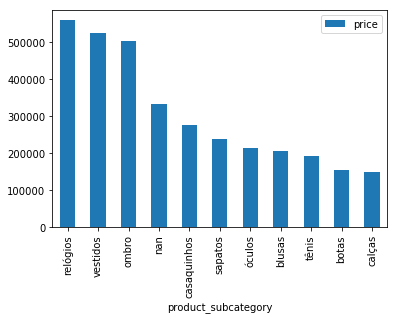

In [183]:
soldProductsByPrice.plot(kind='bar')

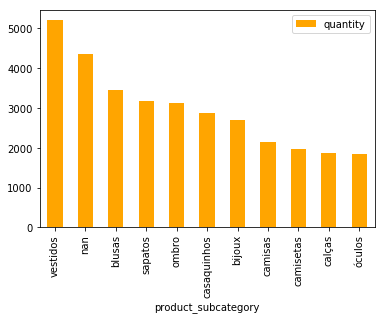

In [184]:
soldProductsByQuantity.plot(kind='bar', color='orange')

**Por preço**: relógios, vestidos, ombro, nan (não especificados), casaquinhos, sapatos, óculos, blusas, tênis, botas, calças.  
**Por quantidade**: vestidos, nan, blusas, sapatos, ombros, casaquinhos, bijoux, camisas, camisetas, calças, óculos.

<li>A grande diferença de primeiros lugares se deve, basicamente, pela diferença entre preços de venda. O preço médio de um relógio fica em torno de 490 unidades monetárias, quando o preço médio dos vestidos passa pouco mais de 100 unidades monetárias.</li>

<h4> 2) O percentual dos usuários que viraram compradores em até 30 dias e em até 90 dias. </h4>
<p>Aqui, foi feito uso das tabelas <i>users</i> e <i>transactions</i> e criada novas colunas em <i>users</i> referentes às datas de criação adicionadas de 30 e 90 dias. Assim, é possível efetuar a comparação entre a data de venda e o intervalo desejado. Os itens que satisfazem às condições impostas, são contadas para, posteriormente, ser feito os calculos. </p>

In [185]:
users['users_30days'] = pd.to_datetime(users['created_at']) + timedelta(days=30)
users['users_90days'] = pd.to_datetime(users['created_at']) + timedelta(days=90)

In [186]:
totalUntil30Days = 0
totalUntil90Days = 0
totalUsers = []
for i in range (0, len(users)):
    for j in range (0, len(transactions)):
        if  transactions.loc[j,'buyer_id'] == users.loc[i,'id'] :
            if transactions.loc[j,'buyer_id'] not in totalUsers:
                totalUsers.append(transactions.loc[j,'buyer_id'])
                if pd.to_datetime(transactions.loc[j,'sold_at']) <= users.loc[i,'users_30days'] and pd.to_datetime(transactions.loc[j,'sold_at']) - users.loc[i,'created_at'] >= timedelta(days=0):
                    totalUntil30Days = totalUntil30Days + 1
                if pd.to_datetime(transactions.loc[j,'sold_at']) <= users.loc[i,'users_90days'] and pd.to_datetime(transactions.loc[j,'sold_at']) - users.loc[i,'created_at'] >= timedelta(days=0):
                    totalUntil90Days = totalUntil90Days + 1

In [187]:
percentUntil30Days = totalUntil30Days/len(users)

In [188]:
percentUntil30Days

0.06747528284578534

In [189]:
percentUntil90Days = totalUntil90Days/len(users)

In [190]:
percentUntil90Days

0.10376108449699317

sendo 6,75% de usuários que viram compradores em até 30 dias e 10,37% de usuários que viram compradores em até 90 dias.

<h4> 3) O percentual dos compradores que volta a comprar. (Taxa de retenção de compradores) </h4>
<p>Neste tópico, é feito o uso da tabela <i>transactions</i>, onde levamos em conta tanto os compradores quanto o número de compras efetuadas por cada um. Considerando apenas o número total de compradores e excluindo os compradores que fizeram apenas uma única compra, é possível achar os compradores que compraram mais de uma vez. O resultado é 44,08%. </p>

In [191]:
transactions['quantity'] = 1
buyersId = transactions.groupby('buyer_id').sum().sort_values('quantity', ascending=False)
len(buyersId[buyersId['quantity'] > 1])
percentOfBuyersThatBuyAgain = len(buyersId[buyersId['quantity'] > 1])/len(transactions.groupby('buyer_id'))

In [192]:
percentOfBuyersThatBuyAgain

0.4408548707753479

<h4> 4) O percentual dos usuários que postam produtos. </h4>
<p>Dado o número total de usuários que postam produtos (<i>products.user_id</i>) e o numero total de usuários cadastrados (<i>users.id</i>), o percentual de usuários que cadastrados que postam produtos é dado pela divisão abaixo:</p>

In [193]:
usersProduct = products.groupby('user_id')
usersTotal =  users.groupby('id')
percentOfUsersThatPostProducts = len(usersProduct)/len(usersTotal)
percentOfUsersThatPostProducts

0.4380797064519417

<p> resultando em um total de 43,80% de usuários que postam produtos.</p>

<h4> 5) O número médio de produtos postados por vendedor. </h4>
<p> É obtida pela soma das quantidades de produtos postados dividida pela contagem dos usuários, resultando em uma média de 19 produtos por usuário.</p>

In [194]:
productsGroupByUserId = products.groupby('user_id').sum()
del productsGroupByUserId['price']
productsGroupByUserId['quantity'].sum()/len(productsGroupByUserId)

19.806188925081432

<h4> 6) O percentual de produtos postados que vendem em até 90 dias.</h4>
<p> Obtido pela divisão entre a quantidade de produtos postados que vendem em até 90 dias e a quantidade total de produtos postados.</p>

In [195]:
productsSold = products[products['state'] == 'sold']
postedSoldUntil90Days = 0
contador = 0
for cont in productsSold['id']:
    product = productsSold[productsSold['id'] == cont]
    productIndex = product.index.values[0]
    for cont_lin in range(0, len(transactions)):
        if  transactions.loc[cont_lin,'product_id'] == products.loc[productIndex,'id'] and str(int(products.loc[productIndex,'user_id'])) == transactions.loc[cont_lin, 'seller_id']:
            if transactions.loc[cont_lin,'sold_at'] - products.loc[productIndex,'created_at'] <= timedelta(days=90) and transactions.loc[cont_lin,'sold_at'] - products.loc[productIndex,'created_at'] >= timedelta(days=0):
                postedSoldUntil90Days = postedSoldUntil90Days + products.loc[productIndex,'quantity']

In [197]:
productsPosted = products['quantity'].sum()

In [199]:
postedSoldUntil90Days/productsPosted

0.056550800568562265

resultando em 5,65% de produtos postados que vendem em até 90 dias.

<h4> Observações</h4>
<li> No segundo item, foi analisado que existem datas de compras anteriores a datas de cadastros. Sendo assim, os resultados apresentados anteriormente não levam em conta as subtrações negativas entre as datas de cadastro e de compra.</li>

<li>No sexto item, é possível perceber que existem itens que foram vendidos, mas não apresentam cadastro. Esses itens precisam ser tratados com atenção e não serão inclusos nos cálculos. </li>

